<a href="https://colab.research.google.com/github/my2403/GPS/blob/main/NGUYENHADIEMMY_GPS_SPARK.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pyspark py4j

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=021adddcd1c56eaa99eb2b7ffa526f05ff0345d48864ab3d5b2ca512b40d0f79
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import lit, col, explode, initcap, regexp_replace, split, concat, substring, to_date
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, FloatType, DoubleType

In [ ]:
# Khởi tạo một phiên Spark
spark = SparkSession.builder.appName("PySparkGooglePlayStore").getOrCreate()

In [ ]:
app =spark.read.csv("/content/drive/MyDrive/Colab Notebooks/Google-Playstore.csv",sep = ',', header= True, inferSchema=True)

In [ ]:
app.count()

1048575

In [ ]:

app.printSchema()

root
 |-- App Name: string (nullable = true)
 |-- App Id: string (nullable = true)
 |-- Category: string (nullable = true)
 |-- Rating: string (nullable = true)
 |-- Rating Count: string (nullable = true)
 |-- Installs: string (nullable = true)
 |-- Minimum Installs: string (nullable = true)
 |-- Maximum Installs: string (nullable = true)
 |-- Free: string (nullable = true)
 |-- Price: string (nullable = true)
 |-- Currency: string (nullable = true)
 |-- Size: string (nullable = true)
 |-- Minimum Android: string (nullable = true)
 |-- Developer Id: string (nullable = true)
 |-- Developer Website: string (nullable = true)
 |-- Developer Email: string (nullable = true)
 |-- Released: string (nullable = true)
 |-- Last Updated: string (nullable = true)
 |-- Content Rating: string (nullable = true)
 |-- Privacy Policy: string (nullable = true)
 |-- Ad Supported: string (nullable = true)
 |-- In App Purchases: string (nullable = true)
 |-- Editors Choice: boolean (nullable = true)



In [ ]:

app.show(2)

+-------------------+--------------------+---------+------+------------+--------+----------------+----------------+----+-----+--------+----+---------------+--------------------+--------------------+--------------------+---------+------------+--------------+--------------------+------------+----------------+--------------+
|           App Name|              App Id| Category|Rating|Rating Count|Installs|Minimum Installs|Maximum Installs|Free|Price|Currency|Size|Minimum Android|        Developer Id|   Developer Website|     Developer Email| Released|Last Updated|Content Rating|      Privacy Policy|Ad Supported|In App Purchases|Editors Choice|
+-------------------+--------------------+---------+------+------------+--------+----------------+----------------+----+-----+--------+----+---------------+--------------------+--------------------+--------------------+---------+------------+--------------+--------------------+------------+----------------+--------------+
|            Gakondo| com.is

**Chúng ta không cần tất cả các cột mà chỉ cần một số ít, vì vậy hãy bắt đầu bằng cách chọn các cột mong muốn**

In [ ]:
apps = app.select("App Name", "Category", "Rating", "Rating Count", "Installs",
                            "Minimum Installs", "Maximum Installs", "Free", "Price","Currency",
                  "Size", "Released","Last Updated", "Content Rating")


**Cột cần thiết cho phân tích**

App Name: Tên của ứng dụng (cho việc xác định ứng dụng).

Category: Thể loại của ứng dụng (cho phân tích thị trường và xu hướng).

Rating: Điểm đánh giá của ứng dụng (cho việc đánh giá chất lượng).

Rating Count: Số lượng đánh giá đã được ứng dụng nhận được (cho việc đánh giá phổ biến).

Installs: Số lần cài đặt của ứng dụng (cho việc xác định sự phổ biến).

Minimum Installs   : Số lượng cài đặt tối thiểu yêu cầu để hiển thị

Maximum Installs  : Số lượng cài đặt tối đa mà ứng dụng này có thể đạt được

Free: Cho biết ứng dụng có phải là miễn phí hay không (cho phân tích mô hình kinh doanh).

Price: Giá của ứng dụng (cho phân tích mô hình kinh doanh).

Currency: Đơn vị tiền

Size: Kích thước của ứng dụng (cho việc đánh giá tài nguyên cần thiết).

Released: Ngày phát hành của ứng dụng

Last Updated: Ngày cập nhật gần nhất của ứng dụng (cho việc xác định sự cập nhật và duy trì).

Content Rating: Phân loại nội dung của ứng dụng (cho việc hiểu đối tượng sử dụng).

In [ ]:
# Biến đổi dữ liệu cho các cột cần thiết
apps = apps \
    .withColumnRenamed("App Name", "app_name") \
    .withColumnRenamed("Category", "category") \
    .withColumn("Rating", col("Rating").cast(DoubleType())) \
    .withColumn("Rating Count", col("Rating Count").cast(IntegerType())) \
    .withColumn("Installs", regexp_replace(col("Installs"), "[^0-9]", "")) \
    .withColumn("Installs", col("Installs").cast(IntegerType())) \
    .withColumn("Price", regexp_replace(col("Price"), "[$]", "")) \
    .withColumn("Price", col("Price").cast(DoubleType())) \
    .withColumn("Size", regexp_replace(col("Size"), "[A-Za-z]+", "")) \
    .withColumn("Size", regexp_replace(col("Size"), "[,]", "")) \
    .withColumn("Size", col("Size").cast(DoubleType())) \
    .withColumnRenamed("Content Rating", "content_rating")



In [ ]:
#NULL => 0 cho cột "price"
apps = apps.fillna(0, "price")


In [ ]:
apps.printSchema()

root
 |-- app_name: string (nullable = true)
 |-- category: string (nullable = true)
 |-- Rating: double (nullable = true)
 |-- Rating Count: integer (nullable = true)
 |-- Installs: integer (nullable = true)
 |-- Minimum Installs: string (nullable = true)
 |-- Maximum Installs: string (nullable = true)
 |-- Free: string (nullable = true)
 |-- Price: double (nullable = false)
 |-- Currency: string (nullable = true)
 |-- Size: double (nullable = true)
 |-- Released: string (nullable = true)
 |-- Last Updated: string (nullable = true)
 |-- content_rating: string (nullable = true)



In [ ]:
apps.show(3)

+-------------------+------------+------+------------+--------+----------------+----------------+----+-----+--------+----+---------+------------+--------------+
|           app_name|    category|Rating|Rating Count|Installs|Minimum Installs|Maximum Installs|Free|Price|Currency|Size| Released|Last Updated|content_rating|
+-------------------+------------+------+------------+--------+----------------+----------------+----+-----+--------+----+---------+------------+--------------+
|            Gakondo|   Adventure|   0.0|           0|      10|              10|              15|TRUE|  0.0|     USD|10.0|26-Feb-20|   26-Feb-20|      Everyone|
|Ampere Battery Info|       Tools|   4.4|          64|    5000|            5000|            7662|TRUE|  0.0|     USD| 2.9|21-May-20|    6-May-21|      Everyone|
|             Vibook|Productivity|   0.0|           0|      50|              50|              58|TRUE|  0.0|     USD| 3.7| 9-Aug-19|   19-Aug-19|      Everyone|
+-------------------+------------+

In [ ]:
#tạo một view tạm thời có tên "apps" từ DataFrame apps trong Spark SQL.
apps.createOrReplaceTempView("apps")

# **Data Analysis**

**1.	Phân tích tổng số ứng dụng có trong tập dữ liệu**

In [ ]:
# Tính tổng số ứng dụng có trong tập dữ liệu
total_apps = spark.sql("SELECT COUNT(*) AS total_apps FROM apps").collect()[0]["total_apps"]
print("Tổng số ứng dụng có trong tập dữ liệu là:", total_apps)

Tổng số ứng dụng có trong tập dữ liệu là: 1048575


In [ ]:
# Phân tích số lượng ứng dụng theo thể loại
apps_per_category = spark.sql("""
    SELECT category, COUNT(*) AS Total_Apps
    FROM apps
    GROUP BY category
    ORDER BY Total_Apps DESC
""")

apps_per_category.show(truncate=False)


+-----------------+----------+
|category         |Total_Apps|
+-----------------+----------+
|Education        |109086    |
|Music & Audio    |70310     |
|Tools            |65331     |
|Business         |65008     |
|Entertainment    |62672     |
|Lifestyle        |53838     |
|Books & Reference|53029     |
|Personalization  |40464     |
|Health & Fitness |37770     |
|Productivity     |36183     |
|Shopping         |34290     |
|Food & Drink     |33480     |
|Travel & Local   |30502     |
|Finance          |29625     |
|Arcade           |24425     |
|Puzzle           |23104     |
|Casual           |22846     |
|Communication    |21774     |
|Sports           |21435     |
|Social           |20335     |
+-----------------+----------+
only showing top 20 rows



**2.	Phân tích điểm đánh giá trung bình cho mỗi ứng dụng.**

*Người dùng*:

* Biết được điểm đánh giá trung bình của một ứng dụng có thể giúp họ quyết định liệu họ nên tải ứng dụng đó hay không.  

* Điểm đánh giá cao => đề xuất ứng dụng đó có chất lượng tốt và được người dùng đánh giá cao.


*Nhà phát triển ứng dụng*:

*   Đánh giá điểm trung bình của các ứng dụng của họ => nhà phát triển hiểu về cách người dùng đánh giá ứng dụng của họ.


* Nếu điểm đánh giá trung bình thấp => cần phải cải thiện sản phẩm của mình để tăng cường trải nghiệm người dùng và tăng cơ hội thu hút người dùng mới



In [ ]:
# điểm đánh giá trung bình cho mỗi ứng dụng
averagerating_per_app = spark.sql("""
    SELECT app_name, AVG(Rating) AS average_rating
    FROM apps
    GROUP BY app_name
""")

averagerating_per_app.show()



+--------------------+--------------+
|            app_name|average_rating|
+--------------------+--------------+
|Wildflower Health...|           0.0|
|Katrina Kaif Wall...|           3.9|
|  Western Movies App|           3.8|
|Free Nickname gen...|           4.0|
|          하늘샘교회|           0.0|
|             Hanover|           4.7|
|Nostradamus: Prop...|           0.0|
|قصص انجليزية مترج...|           4.3|
|Navratri Video St...|           3.3|
|    Изобилие Барнаул|           0.0|
|               POLYX|           4.0|
|        Miltown Eats|           0.0|
|             Veeroam|           0.0|
|  Phrasebook Chinese|           4.0|
|Pocketuse - India...|           4.9|
|   The Branding Iron|           0.0|
|          Netcom GPS|           0.0|
|Trigonometry Calc...|           4.5|
|       Brilho do Sol|           3.9|
|Bulgarian Hindi d...|           0.0|
+--------------------+--------------+
only showing top 20 rows



**3.	Phân tích 5 ứng dụng được đánh giá cao nhất, sắp xếp theo số lượng đánh giá.**

+--------------------+------+------------+
|            app_name|Rating|Rating Count|
+--------------------+------+------------+
|  WhatsApp Messenger|   4.0|   138557570|
|           Instagram|   3.8|   120206190|
|             YouTube|   4.4|   112440547|
|Garena Free Fire ...|   4.2|    89177097|
|      Clash of Clans|   4.5|    56025424|
+--------------------+------+------------+



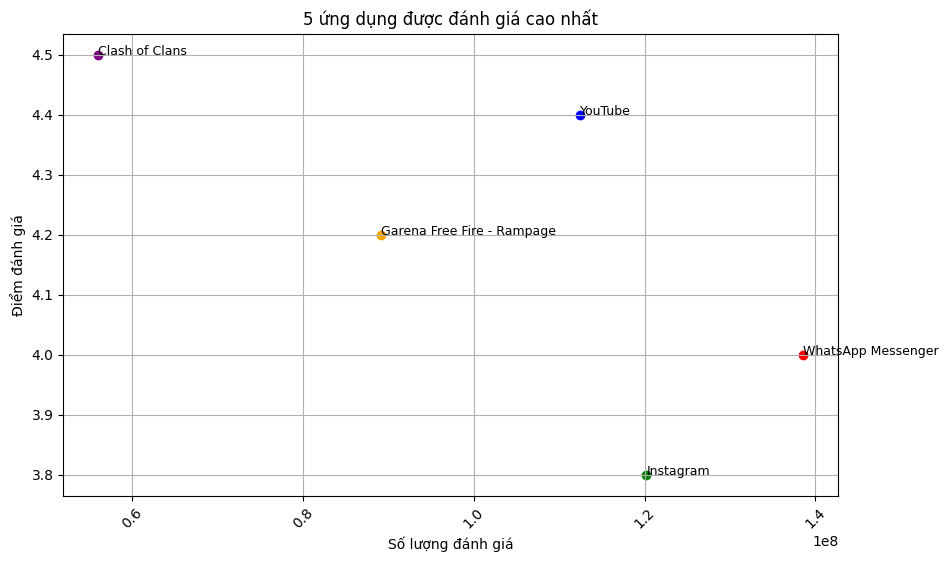

In [ ]:
#  5 ứng dụng được đánh giá cao nhất
top_rated_apps = spark.sql("""
    SELECT app_name, Rating, `Rating Count`
    FROM apps
    ORDER BY `Rating Count` DESC
    LIMIT 5
""")

top_rated_apps.show()


import matplotlib.pyplot as plt


app_names = top_rated_apps.select('app_name').rdd.flatMap(lambda x: x).collect()
ratings = top_rated_apps.select('Rating').rdd.flatMap(lambda x: x).collect()
rating_counts = top_rated_apps.select('Rating Count').rdd.flatMap(lambda x: x).collect()


colors = ['red', 'green', 'blue', 'orange', 'purple']

# Vẽ biểu đồ phân tán
plt.figure(figsize=(10, 6))
for i in range(len(app_names)):
    plt.scatter(rating_counts[i], ratings[i], color=colors[i])
    plt.text(rating_counts[i], ratings[i], app_names[i], fontsize=9)
plt.title('5 ứng dụng được đánh giá cao nhất')
plt.xlabel('Số lượng đánh giá')
plt.ylabel('Điểm đánh giá')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


**4. Phân tích số điểm trung binh đánh giá cho các ứng dụng hàng đầu.**

In [ ]:
import matplotlib.pyplot as plt

top_10_rating_installs = spark.sql("""
    SELECT app_name, AVG(Rating) AS average_rating, Installs
    FROM apps
    GROUP BY app_name, Installs
    ORDER BY Installs DESC
    LIMIT 10
""")
top_10_rating_installs.show()




+--------------------+--------------+----------+
|            app_name|average_rating|  Installs|
+--------------------+--------------+----------+
|Skype - free IM &...|           4.3|1000000000|
|Dropbox: Cloud St...|           4.2|1000000000|
|  Google Street View|           4.2|1000000000|
|Google Play Books...|           4.1|1000000000|
|     Samsung Gallery|           4.5|1000000000|
|             Netflix|           4.4|1000000000|
|           Instagram|           3.8|1000000000|
|   ANT Radio Service|           4.0|1000000000|
|Samsung Experienc...|           4.2|1000000000|
|       Samsung Email|           4.3|1000000000|
+--------------------+--------------+----------+



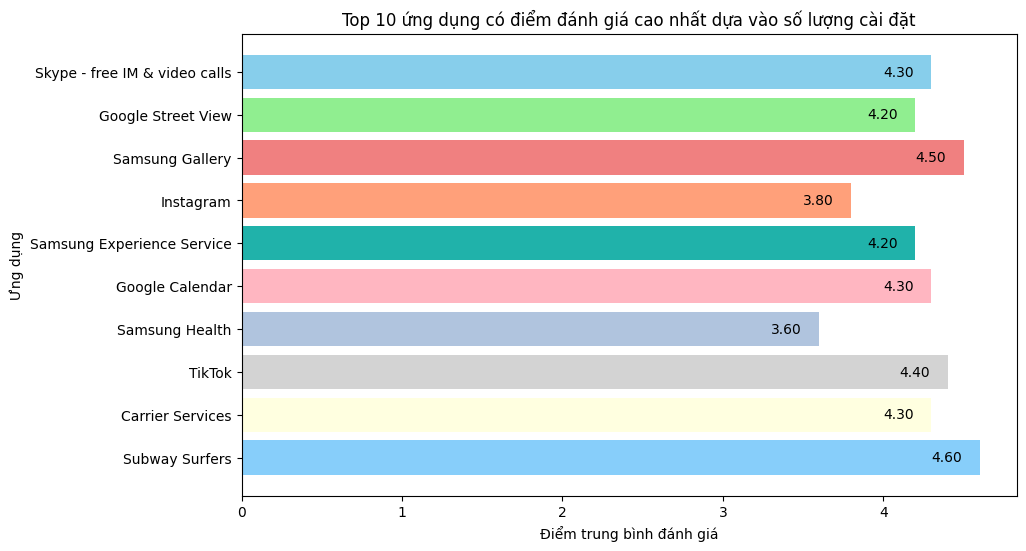

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
app_names = top_10_rating_installs.select("app_name").rdd.flatMap(lambda x: x).collect()
average_ratings = top_10_rating_installs.select("average_rating").rdd.flatMap(lambda x: x).collect()
installs = top_10_rating_installs.select("Installs").rdd.flatMap(lambda x: x).collect()

colors = ['skyblue', 'lightgreen', 'lightcoral', 'lightsalmon', 'lightseagreen',
          'lightpink', 'lightsteelblue', 'lightgrey', 'lightyellow', 'lightskyblue']


plt.figure(figsize=(10, 6))
bars = plt.barh(app_names, average_ratings, color=colors)

for bar, rating in zip(bars, average_ratings):
    plt.text(bar.get_width() - 0.3, bar.get_y() + bar.get_height()/2,
             f'{rating:.2f}', va='center', color='black')

plt.xlabel('Điểm trung bình đánh giá')
plt.ylabel('Ứng dụng')
plt.title('Top 10 ứng dụng có điểm đánh giá cao nhất dựa vào số lượng cài đặt')
plt.gca().invert_yaxis()



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
#Lấy thông tin về top 10 số điểm trung bình đánh giá cho các ứng dụng hàng đầu dựa vào số lượt cài đặt
top_10_rating_installs_details = spark.sql("""
    SELECT app_name, AVG(Rating) AS average_rating, Installs, category
    FROM apps
    WHERE app_name IN (
        SELECT app_name
        FROM (
            SELECT app_name
            FROM apps
            GROUP BY app_name, Installs
            ORDER BY Installs DESC
            LIMIT 10
        ) AS top_10_apps
    )
    GROUP BY app_name, Installs, category
""")

top_10_rating_installs_details.show()

+--------------------+--------------+----------+----------------+
|            app_name|average_rating|  Installs|        category|
+--------------------+--------------+----------+----------------+
|Samsung Experienc...|           4.2|1000000000|           Tools|
|     Google Calendar|           4.3|1000000000|    Productivity|
|  Google Street View|           4.2|1000000000|  Travel & Local|
|     Samsung Gallery|           4.5|1000000000|     Photography|
|Skype - free IM &...|           4.3|1000000000|   Communication|
|           Instagram|           3.8|1000000000|          Social|
|      Samsung Health|           3.6|1000000000|Health & Fitness|
|              TikTok|           4.4|1000000000|          Social|
|    Carrier Services|           4.3|1000000000|   Communication|
|      Subway Surfers|           4.6|1000000000|          Arcade|
+--------------------+--------------+----------+----------------+



**5.	Phân tích Top 10 ứng dụng free sử dụng nhiều nhất**

Nhận biết được xu hướng sử dụng của người dùng và tiềm năng thị trường cho các ứng dụng miễn phí.



In [ ]:
#  lấy top 10 ứng dụng miễn phí được sử dụng nhiều nhất
top_free_apps = spark.sql("""
    SELECT app_name, Installs
    FROM apps
    WHERE Free = True
    ORDER BY Installs DESC
    LIMIT 10
""")

top_free_apps.show()


+--------------------+----------+
|            app_name|  Installs|
+--------------------+----------+
|       Samsung Email|1000000000|
|            Messages|1000000000|
|     Samsung Gallery|1000000000|
|SHAREit - Transfe...|1000000000|
|             Netflix|1000000000|
|    Carrier Services|1000000000|
|     Google Calendar|1000000000|
|Google Play Servi...|1000000000|
|              TikTok|1000000000|
|         Device Care|1000000000|
+--------------------+----------+



Ứng dụng có kích thước lớn nhất:
+--------+------+
|app_name|  Size|
+--------+------+
| palette|1024.0|
+--------+------+

Ứng dụng có kích thước nhỏ nhất:
+--------------------+----+
|            app_name|Size|
+--------------------+----+
|Tic Tac Toe Onlin...| 1.0|
+--------------------+----+



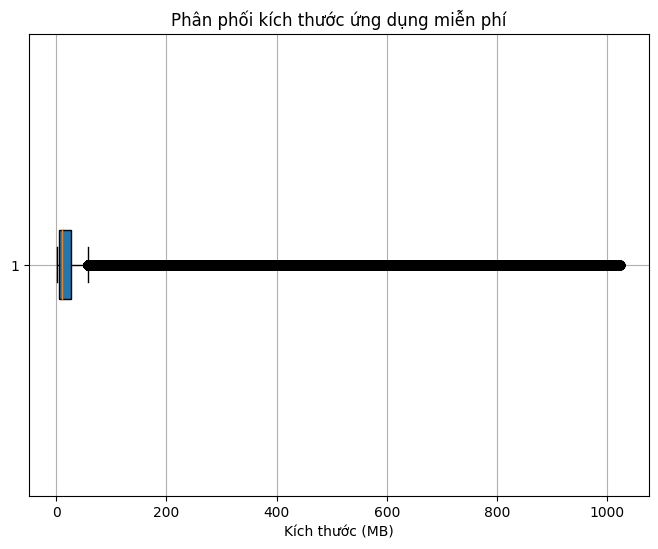

In [ ]:
# Lấy thông tin về kích thước ứng dụng của các ứng dụng miễn phí
size_analysis = spark.sql("""
    SELECT app_name, Size
    FROM apps
    WHERE Free = True
""")
largest_size_app = size_analysis.orderBy(size_analysis['Size'].desc()).limit(1)
non_null_size_apps = size_analysis.filter(size_analysis['Size'].isNotNull())
smallest_size_app = non_null_size_apps.orderBy(non_null_size_apps['Size']).limit(1)
print("Ứng dụng có kích thước lớn nhất:")
largest_size_app.show()
print("Ứng dụng có kích thước nhỏ nhất:")
smallest_size_app.show()


# Lấy kích thước ứng dụng từ kết quả phân tích kích thước
sizes = non_null_size_apps.select('Size').rdd.flatMap(lambda x: x).collect()

plt.figure(figsize=(8, 6))
plt.boxplot(sizes, vert=False, patch_artist=True)
plt.title('Phân phối kích thước ứng dụng miễn phí')
plt.xlabel('Kích thước (MB)')
plt.grid(True)
plt.show()


**6.	Phân tích mối quan hệ giữa điểm đánh giá trung bình của ứng dụng và số lượng cài đặt, để hiểu liệu việc đánh giá cao có ảnh hưởng tích cực đến sự phổ biến của ứng dụng hay không.**

 Xác định mối quan hệ giữa điểm đánh giá và số lượng cài đặt => đánh giá xem liệu việc đánh giá cao có ảnh hưởng tích cực đến sự phổ biến của ứng dụng hay không


+----------+--------------+
|avg_rating|total_installs|
+----------+--------------+
|      2.21|  154750256920|
+----------+--------------+



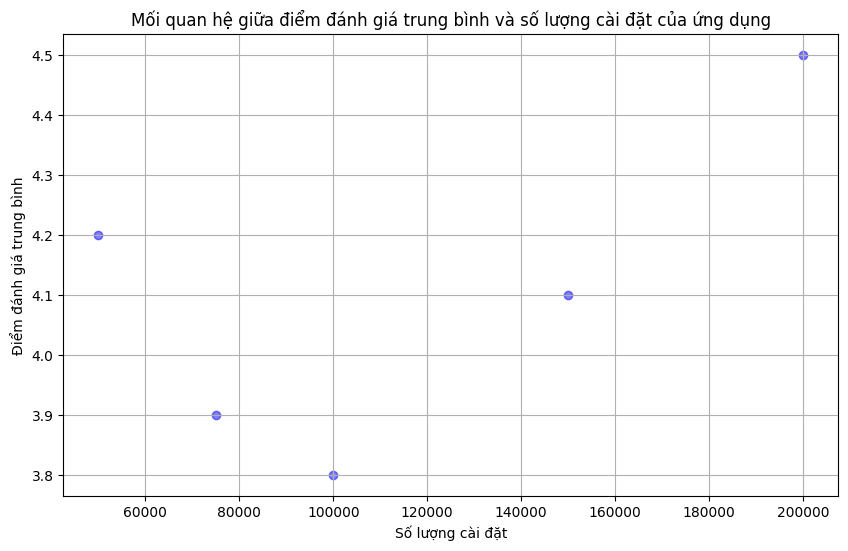

In [ ]:
relationship_app = spark.sql("""
    SELECT ROUND(AVG(`Rating`), 2) AS avg_rating,
    SUM(`Installs`) AS total_installs
    FROM apps
""")

relationship_app.show()


# Dữ liệu điểm đánh giá trung bình và số lượng cài đặt
average_ratings = [4.2, 3.8, 4.5, 3.9, 4.1]  # Điểm đánh giá trung bình của ứng dụng
installs = [50000, 100000, 200000, 75000, 150000]  # Số lượng cài đặt của ứng dụng

# Vẽ biểu đồ Scatter Plot
plt.figure(figsize=(10, 6))
plt.scatter(installs, average_ratings, color='blue', alpha=0.5)

# Đặt tên
plt.xlabel('Số lượng cài đặt')
plt.ylabel('Điểm đánh giá trung bình')
plt.title('Mối quan hệ giữa điểm đánh giá trung bình và số lượng cài đặt của ứng dụng')

# Hiển thị biểu đồ
plt.grid(True)
plt.show()

Dựa trên biểu đồ scatter plot, không có mối quan hệ rõ ràng giữa điểm đánh giá trung bình và số lượng cài đặt của ứng dụng

=> Đánh giá cao không nhất thiết dẫn đến sự phổ biến cao của ứng dụng



**7.	Phân tích 3 thể loại ứng dụng nào có số lượng cài đặt cao nhất?**

+-------------+--------------+
|     category|total_installs|
+-------------+--------------+
|        Tools|   20518199547|
|Communication|    8771005525|
|       Action|    8683886021|
+-------------+--------------+



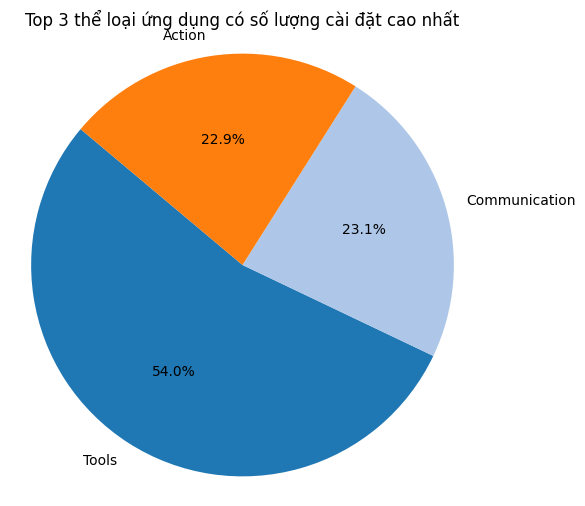

In [ ]:
most_installed = spark.sql("""
    SELECT category, SUM(Installs) AS total_installs
    FROM apps
    GROUP BY category
    ORDER BY total_installs DESC
    LIMIT 3
""")

most_installed.show()



# Lấy dữ liệu từ DataFrame để vẽ biểu đồ tròn
categories = most_installed.select("category").rdd.flatMap(lambda x: x).collect()
installs = most_installed.select("total_installs").rdd.flatMap(lambda x: x).collect()

# Tạo biểu đồ tròn với màu sắc đa dạng
plt.figure(figsize=(6, 6))
plt.pie(installs, labels=categories, autopct='%1.1f%%', startangle=140, colors=plt.cm.tab20.colors)
plt.title('Top 3 thể loại ứng dụng có số lượng cài đặt cao nhất')
plt.axis('equal')  # Đảm bảo biểu đồ tròn
plt.show()

In [ ]:
from pyspark.sql.window import Window
import pyspark.sql.functions as F

# Tính tổng số lượng cài đặt của mỗi thể loại ứng dụng cho mỗi năm và xếp hạng theo số lượng cài đặt
install_trend = spark.sql("""
    SELECT Release_Year, category, Total_Installs
    FROM (
        SELECT SUBSTR(Released, -2) AS Release_Year, category, SUM(Installs) AS Total_Installs,
               RANK() OVER (PARTITION BY SUBSTR(Released, -2) ORDER BY SUM(Installs) DESC) AS category_rank
        FROM apps
        WHERE Released IS NOT NULL
        GROUP BY SUBSTR(Released, -2), category
    ) ranked
    WHERE category_rank <= 2
    ORDER BY Release_Year, category_rank
""")

# Hiển thị kết quả
install_trend.show(truncate=False)

+------------+-------------+--------------+
|Release_Year|category     |Total_Installs|
+------------+-------------+--------------+
|10          |Communication|2362947000    |
|10          |Productivity |1776322950    |
|11          |Entertainment|1383143010    |
|11          |Tools        |740662286     |
|12          |Productivity |1924016901    |
|12          |Arcade       |1908970690    |
|13          |Tools        |3093709572    |
|13          |Casual       |1055443026    |
|14          |Music & Audio|1324589360    |
|14          |Tools        |1266577078    |
|15          |Tools        |1656576512    |
|15          |Social       |1174802508    |
|16          |Tools        |1652478006    |
|16          |Action       |1148961118    |
|17          |Tools        |3659690706    |
|17          |Communication|1695561341    |
|18          |Tools        |3436944535    |
|18          |Action       |1690412740    |
|19          |Tools        |1440182867    |
|19          |Arcade       |9839

In [ ]:
import matplotlib.pyplot as plt

# Dữ liệu từ DataFrame
years = install_trend.select("Release_Year").distinct().rdd.flatMap(lambda x: x).collect()
categories = install_trend.select("category").distinct().rdd.flatMap(lambda x: x).collect()

# Tạo DataFrame theo năm và thể loại
data = {year: [install_trend.filter((F.col("Release_Year") == year) & (F.col("category") == category))
                .select(F.sum("Total_Installs")).collect()[0][0] or 0 for category in categories]
        for year in years}

# Vẽ biểu đồ đường
plt.figure(figsize=(10, 6))
for category in categories:
    plt.plot(years, [data[year][categories.index(category)] for year in years], label=category)

plt.title('Xu hướng cài đặt của các thể loại ứng dụng qua các năm')
plt.xlabel('Năm')
plt.ylabel('Tổng số lượng cài đặt')
plt.xticks(years)
plt.legend()
plt.grid(True)
plt.show()



ERROR:root:KeyboardInterrupt while sending command.
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
  File "/usr/local/lib/python3.10/dist-packages/py4j/clientserver.py", line 511, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
  File "/usr/lib/python3.10/socket.py", line 705, in readinto
    return self._sock.recv_into(b)
KeyboardInterrupt


KeyboardInterrupt: 

**8.	Phân tích Xu hướng phổ biến về các tính năng miễn phí và có phí trong các ứng dụng là gì?**

In [ ]:
# Đếm số lượng ứng dụng miễn phí và có phí
free_vs_paid = spark.sql("""
    SELECT Free, COUNT(*) AS total_apps
    FROM apps
    GROUP BY Free
""")


free_vs_paid.show()

+-----+----------+
| Free|total_apps|
+-----+----------+
|FALSE|     20573|
|    0|         1|
| TRUE|   1027989|
| 1000|         2|
|  500|         1|
|12844|         1|
|   10|         1|
|   51|         1|
|   15|         1|
|10000|         1|
|  100|         1|
| 2556|         1|
|52167|         1|
|   50|         1|
+-----+----------+



Sự chênh lệch rất lớn giữa số lượng ứng dụng miễn phí và có phí cho thấy rằng mô hình kinh doanh miễn phí vẫn chiếm ưu thế trong thị trường ứng dụng

**Tổng doanh thu từ các ứng dụng có phí mỗi năm hiểu được xu hướng phát triển của doanh thu từ các ứng dụng có phí trên thị trường qua các năm**

+------------+------------------+
|Release_Year|     Total_Revenue|
+------------+------------------+
|          10|1794.3887010000024|
|          11| 4876.408613999978|
|          12| 6275.843543999931|
|          13| 7365.023182999849|
|          14| 9399.260646999786|
|          15| 8282.896992999837|
|          16|10329.344390999773|
|          17|11346.029496999688|
|          18|11983.428624999693|
|          19|15925.646194999623|
|          20| 16665.02190099964|
|          21|1131.8000000000015|
|          om|               0.0|
+------------+------------------+



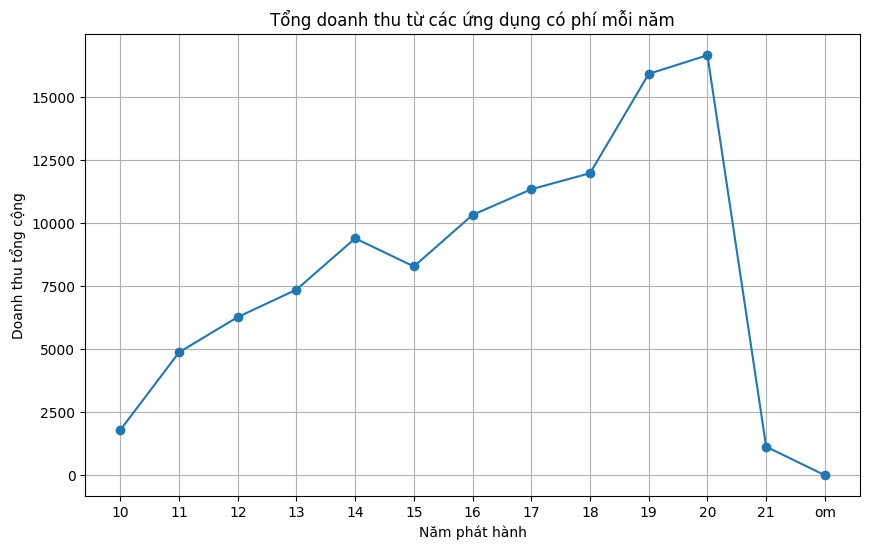

In [ ]:
# Tính tổng doanh thu từ các ứng dụng có phí mỗi năm
revenue_per_year = spark.sql("""
    SELECT SUBSTR(Released, -2) AS Release_Year, SUM(Price) AS Total_Revenue
    FROM apps
    WHERE Free = False AND Released IS NOT NULL
    GROUP BY SUBSTR(Released, -2)
    ORDER BY Release_Year
""")
import matplotlib.pyplot as plt
# Hiển thị tổng doanh thu từ các ứng dụng có phí mỗi năm
revenue_per_year.show()

# Chuyển đổi dữ liệu từ DataFrame sang danh sách Python
years = revenue_per_year.select("Release_Year").rdd.flatMap(lambda x: x).collect()
revenues = revenue_per_year.select("Total_Revenue").rdd.flatMap(lambda x: x).collect()

# Tạo biểu đồ đường
plt.figure(figsize=(10, 6))
plt.plot(years, revenues, marker='o', linestyle='-')
plt.title('Tổng doanh thu từ các ứng dụng có phí mỗi năm')
plt.xlabel('Năm phát hành')
plt.ylabel('Doanh thu tổng cộng')
plt.grid(True)
plt.show()

**So sánh tổng doanh thu và lợi nhuận của các ứng dụng có phí**

In [ ]:
# Tính lợi nhuận từ các ứng dụng có phí
revenue_profit = spark.sql("""
    SELECT
        App_Name,
        Price,
        Installs,
        Price * Installs AS Revenue,
        (Price * Installs) - Price AS Profit
    FROM
        apps
    WHERE
        Free = FALSE
""")


total_revenue_profit = revenue_profit.selectExpr("SUM(Revenue) as Total_Revenue", "SUM(Profit) as Total_Profit")
total_revenue_profit.show()


# top 3 ứng dụng có phí thuộc thể loại có lợi nhuận cao nhất
top_profit_apps = spark.sql("""
    SELECT
        App_Name, Category, Price, Installs, Price * Installs AS Revenue, (Price * Installs) - Price AS Profit
    FROM
        apps
    WHERE
        Free = FALSE
    ORDER BY
        Profit DESC
    LIMIT 3
""")

# Hiển thị top 3 ứng dụng có lợi nhuận cao nhất
top_profit_apps.show()

+-------------------+-------------------+
|      Total_Revenue|       Total_Profit|
+-------------------+-------------------+
|7.143838915442727E8|7.142769695489255E8|
+-------------------+-------------------+

+--------------------+-------------+-----+--------+---------+-------------+
|            App_Name|     Category|Price|Installs|  Revenue|       Profit|
+--------------------+-------------+-----+--------+---------+-------------+
|           Minecraft|       Arcade| 7.49|10000000|   7.49E7|7.489999251E7|
|OfficeSuite Pro +...|     Business|19.99| 1000000|  1.999E7|1.998998001E7|
|TuneIn Pro: Live ...|Music & Audio| 9.99| 1000000|9990000.0|   9989990.01|
+--------------------+-------------+-----+--------+---------+-------------+



Tổng doanh thu từ các ứng dụng có phí là khoảng 714,383,892 đô la. Tổng lợi nhuận từ các ứng dụng này là gần như bằng với tổng doanh thu, với khoảng 714,276,970 đô la.

**9.Phân tích tổng số ứng dụng được phát hành mỗi năm**

Số lượng ứng dụng được phát hành mỗi năm từ 2010 - 2021.

=> Điều này nhận biết xu hướng phát triển của ứng dụng qua các năm và phân tích sự tăng trưởng hoặc giảm giới hạn của thị trường ứng dụng

In [ ]:
# Hiển thị dữ liệu trong cột "Released"
spark.sql("SELECT Released FROM apps LIMIT 10").show()# Hiển thị dữ liệu trong cột "Released"
spark.sql("SELECT Released FROM apps LIMIT 10").show()
apps_per_year = spark.sql("""
    SELECT SUBSTR(Released, -2) AS Release_Year, COUNT(*) AS Total_Apps
    FROM apps
    WHERE Released IS NOT NULL
    GROUP BY SUBSTR(Released, -2)
    ORDER BY Release_Year
""")
apps_per_year.show()

+---------+
| Released|
+---------+
|26-Feb-20|
|21-May-20|
| 9-Aug-19|
|10-Sep-18|
|21-Feb-20|
|24-Dec-18|
|23-Sep-19|
|21-Jun-19|
|     NULL|
|22-Sep-19|
+---------+

+---------+
| Released|
+---------+
|26-Feb-20|
|21-May-20|
| 9-Aug-19|
|10-Sep-18|
|21-Feb-20|
|24-Dec-18|
|23-Sep-19|
|21-Jun-19|
|     NULL|
|22-Sep-19|
+---------+

+------------+----------+
|Release_Year|Total_Apps|
+------------+----------+
|          10|      2040|
|          11|      6489|
|          12|     11641|
|          13|     19231|
|          14|     32538|
|          15|     52434|
|          16|     76089|
|          17|    117984|
|          18|    151624|
|          19|    217637|
|          20|    247293|
|          21|     81524|
|          et|         1|
|          kr|         1|
|          om|        13|
|          ua|         1|
+------------+----------+



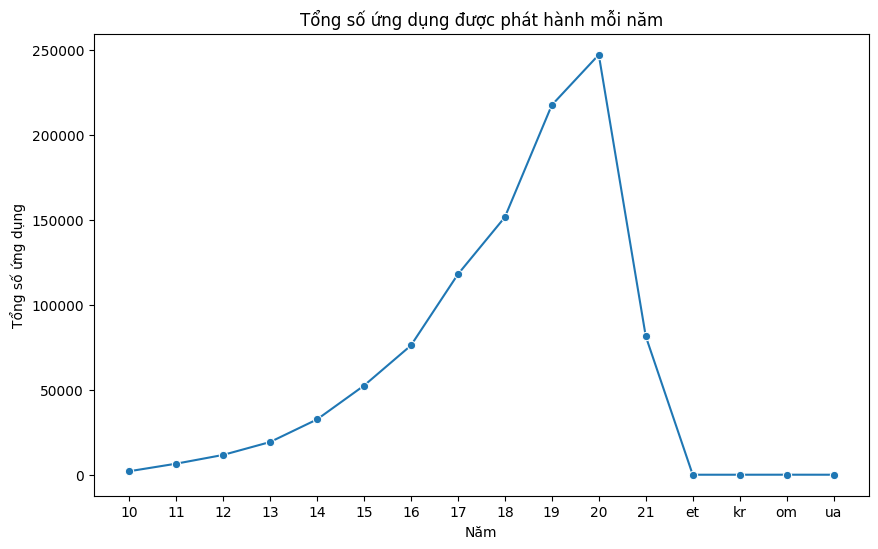

In [ ]:
import seaborn as sns
apps_per_year_pd = apps_per_year.toPandas()

plt.figure(figsize=(10, 6))
sns.lineplot(data=apps_per_year_pd, x='Release_Year', y='Total_Apps', marker='o')

plt.title('Tổng số ứng dụng được phát hành mỗi năm')
plt.xlabel('Năm')
plt.ylabel('Tổng số ứng dụng')

plt.show()



**Thể loại ứng dụng được sử dụng nhiều nhất 2010 & 2021**

In [ ]:
#top 3 thể loại ứng dụng được sử dụng nhiều nhất 2010 & 2021
top_categories_10 = spark.sql("""
    SELECT category, COUNT(*) AS Total_Apps
    FROM apps
    WHERE Released LIKE '%10'
    GROUP BY category
    ORDER BY Total_Apps DESC
    LIMIT 3
""")

top_categories_21 = spark.sql("""
    SELECT category, COUNT(*) AS Total_Apps
    FROM apps
    WHERE Released LIKE '%21'
    GROUP BY category
    ORDER BY Total_Apps DESC
    LIMIT 3
""")

print("Top 3 thể loại ứng dụng được sử dụng nhiều nhất trong các năm kết thúc bằng 2010:")
top_categories_10.show()

print("Top 3 thể loại ứng dụng được sử dụng nhiều nhất trong các năm kết thúc bằng 2021:")
top_categories_21.show()

Top 3 thể loại ứng dụng được sử dụng nhiều nhất trong các năm kết thúc bằng 2010:
+-----------------+----------+
|         category|Total_Apps|
+-----------------+----------+
|            Tools|       243|
|Books & Reference|       166|
| News & Magazines|       136|
+-----------------+----------+

Top 3 thể loại ứng dụng được sử dụng nhiều nhất trong các năm kết thúc bằng 2021:
+-------------+----------+
|     category|Total_Apps|
+-------------+----------+
|    Education|      7494|
|Entertainment|      7342|
|        Tools|      5488|
+-------------+----------+



<ipython-input-38-07813e7398a3>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_categories_10_pd, x='Total_Apps', y='category', palette='viridis')
<ipython-input-38-07813e7398a3>:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_categories_21_pd, x='Total_Apps', y='category', palette='viridis')


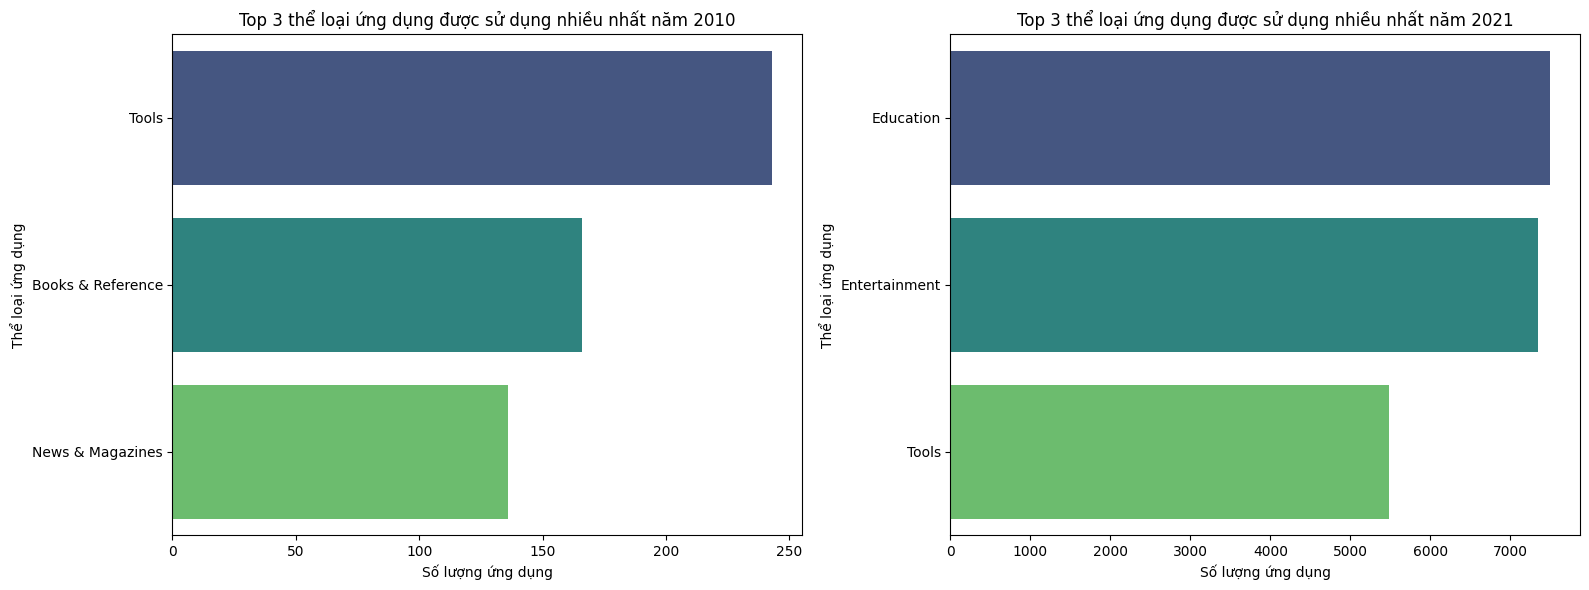

In [ ]:

top_categories_10_pd = top_categories_10.toPandas()
top_categories_21_pd = top_categories_21.toPandas()

plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
sns.barplot(data=top_categories_10_pd, x='Total_Apps', y='category', palette='viridis')
plt.title('Top 3 thể loại ứng dụng được sử dụng nhiều nhất năm 2010')
plt.xlabel('Số lượng ứng dụng')
plt.ylabel('Thể loại ứng dụng')

plt.subplot(1, 2, 2)
sns.barplot(data=top_categories_21_pd, x='Total_Apps', y='category', palette='viridis')
plt.title('Top 3 thể loại ứng dụng được sử dụng nhiều nhất năm 2021')
plt.xlabel('Số lượng ứng dụng')
plt.ylabel('Thể loại ứng dụng')

plt.tight_layout()
plt.show()


Năm kết thúc bằng 2010, top 3 thể loại ứng dụng được sử dụng nhiều nhất là Tools, Books & Reference, và News & Magazines. Điều này cho thấy người dùng thường tập trung vào các ứng dụng công cụ (Tools) cùng với việc đọc sách và tạp chí (Books & Reference, News & Magazines).

Trong khi đó, năm kết thúc bằng 2021, top 3 thể loại ứng dụng được sử dụng nhiều nhất thay đổi, bao gồm Education, Entertainment, và Tools. Có thể thấy xu hướng sử dụng ứng dụng đã dịch chuyển sang các lĩnh vực giáo dục (Education) và giải trí (Entertainment), trong khi các ứng dụng công cụ (Tools) vẫn giữ vững vị trí trong top 3.

Sự thay đổi này có thể phản ánh xu hướng thị trường và sở thích của người dùng trong thời gian. Cụ thể, sự gia tăng của ứng dụng giáo dục có thể liên quan đến nhu cầu học tập và làm việc từ xa trong bối cảnh dịch COVID-19.

**10.Phân tích phân bố của các ứng dụng theo phân loại nội dung**

In [ ]:
## Tính tỷ lệ phân phối của các nhóm phân loại nội dung
content_distribution = spark.sql("""
    SELECT content_rating,
           COUNT(*) AS total_apps,
           ROUND(COUNT(*) * 100.0 / (SELECT COUNT(*) FROM apps), 2) AS distribution_percent
    FROM apps
    WHERE content_rating IN ('Everyone', 'Teen', 'Mature 17+', 'Everyone 10+')
    GROUP BY content_rating
    ORDER BY total_apps DESC
""")

content_distribution.show()

+--------------+----------+--------------------+
|content_rating|total_apps|distribution_percent|
+--------------+----------+--------------------+
|      Everyone|    916620|               87.42|
|          Teen|     89230|                8.51|
|    Mature 17+|     27217|                2.60|
|  Everyone 10+|     15362|                1.47|
+--------------+----------+--------------------+



**3 ứng dụng phổ biến theo từng phân loại nội dung của ứng dụng**

In [ ]:


# Phân tích nhóm "Mature 17+"
mature_17_popular_apps = spark.sql("""
    SELECT app_name, Installs
    FROM apps
    WHERE content_rating = 'Mature 17+'
    ORDER BY Installs DESC
    LIMIT 3
""")

# Phân tích nhóm "Everyone 10+"
everyone_10_popular_apps = spark.sql("""
    SELECT app_name, Installs
    FROM apps
    WHERE content_rating = 'Everyone 10+'
    ORDER BY Installs DESC
    LIMIT 3
""")

# Phân tích nhóm "Everyone"
everyone_popular_apps = spark.sql("""
    SELECT app_name, Installs
    FROM apps
    WHERE content_rating = 'Everyone'
    ORDER BY Installs DESC
    LIMIT 3
""")

# Phân tích nhóm "Teen"
teen_popular_apps = spark.sql("""
    SELECT app_name, Installs
    FROM apps
    WHERE content_rating = 'Teen'
    ORDER BY Installs DESC
    LIMIT 3
""")

print("Nhóm Mature 17+:")
mature_17_popular_apps.show()

print("Nhóm Everyone 10+:")
everyone_10_popular_apps.show()

print("Nhóm Everyone:")
everyone_popular_apps.show()

print("Nhóm Teen:")
teen_popular_apps.show()

Nhóm Mature 17+:
+--------------------+---------+
|            app_name| Installs|
+--------------------+---------+
|Sniper 3D: Fun Fr...|500000000|
|Garena Free Fire ...|500000000|
|            Telegram|500000000|
+--------------------+---------+

Nhóm Everyone 10+:
+--------------+----------+
|      app_name|  Installs|
+--------------+----------+
|      Briefing|1000000000|
|Subway Surfers|1000000000|
|Clash of Clans| 500000000|
+--------------+----------+

Nhóm Everyone:
+--------------------+----------+
|            app_name|  Installs|
+--------------------+----------+
|            Messages|1000000000|
|Dropbox: Cloud St...|1000000000|
|    Carrier Services|1000000000|
+--------------------+----------+

Nhóm Teen:
+--------------------+----------+
|            app_name|  Installs|
+--------------------+----------+
|Spotify: Listen t...|1000000000|
|           Instagram|1000000000|
|Google Play Books...|1000000000|
+--------------------+----------+



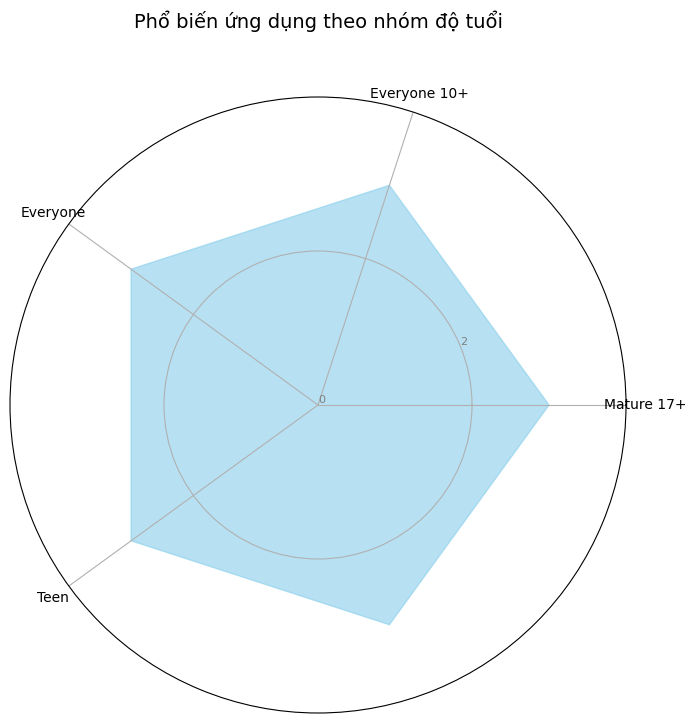

In [ ]:

categories = ['Mature 17+', 'Everyone 10+', 'Everyone', 'Teen']
popularity = [mature_17_popular_apps.count(), everyone_10_popular_apps.count(),
              everyone_popular_apps.count(), teen_popular_apps.count()]


popularity_loop = popularity + [popularity[0]]
theta = np.linspace(0, 2 * np.pi, len(categories) + 1, endpoint=False)

fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
ax.fill(theta, popularity_loop, color='skyblue', alpha=0.6)


ax.set_ylim(0, max(popularity) + 1)
ax.set_yticks(range(0, max(popularity) + 1, 2))
ax.set_yticklabels([str(i) for i in range(0, max(popularity) + 1, 2)], color='grey', size=8)
ax.set_xticks(theta[:-1])
ax.set_xticklabels(categories, size=10)


plt.title('Phổ biến ứng dụng theo nhóm độ tuổi', size=14, color='black', y=1.1)
plt.show()
